In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Connect to the Postgres DB using SQL Alchemy toolkit

In [9]:
from config import username, password, hostname_or_ip, port, DB
from sqlalchemy import create_engine
db_uri = f'postgresql://{username}:{password}@{hostname_or_ip}:{port}/{DB}'
engine = create_engine(db_uri, echo=True) #echo = True to log every query our SQL database executes to the terminal

In [10]:
connection = engine.connect()

2020-07-13 17:57:15,375 INFO sqlalchemy.engine.base.Engine select version()
2020-07-13 17:57:15,376 INFO sqlalchemy.engine.base.Engine {}
2020-07-13 17:57:15,378 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-07-13 17:57:15,378 INFO sqlalchemy.engine.base.Engine {}
2020-07-13 17:57:15,383 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-07-13 17:57:15,384 INFO sqlalchemy.engine.base.Engine {}
2020-07-13 17:57:15,390 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-07-13 17:57:15,391 INFO sqlalchemy.engine.base.Engine {}
2020-07-13 17:57:15,395 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-07-13 17:57:15,397 INFO sqlalchemy.engine.base.Engine {}


## Create a histogram to visualize the most common salary ranges for employees.

### Direct SQL query result to pandas DF

In [18]:
import pandas as pd

query = "SELECT emp.emp_no, sal.salary \
FROM employees AS emp \
LEFT JOIN salaries AS sal \
ON emp.emp_no = sal.emp_no"

Employee_Salary_DF = pd.read_sql(
            query,
            con=connection
)

2020-07-13 18:11:18,420 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2020-07-13 18:11:18,422 INFO sqlalchemy.engine.base.Engine {'name': 'SELECT emp.emp_no, sal.salary FROM employees AS emp LEFT JOIN salaries AS sal ON emp.emp_no = sal.emp_no'}
2020-07-13 18:11:18,427 INFO sqlalchemy.engine.base.Engine SELECT emp.emp_no, sal.salary FROM employees AS emp LEFT JOIN salaries AS sal ON emp.emp_no = sal.emp_no
2020-07-13 18:11:18,428 INFO sqlalchemy.engine.base.Engine {}


### Create histograms
- **Salary range is 40000 to 129492**
- **Mean salary is 52970.7**

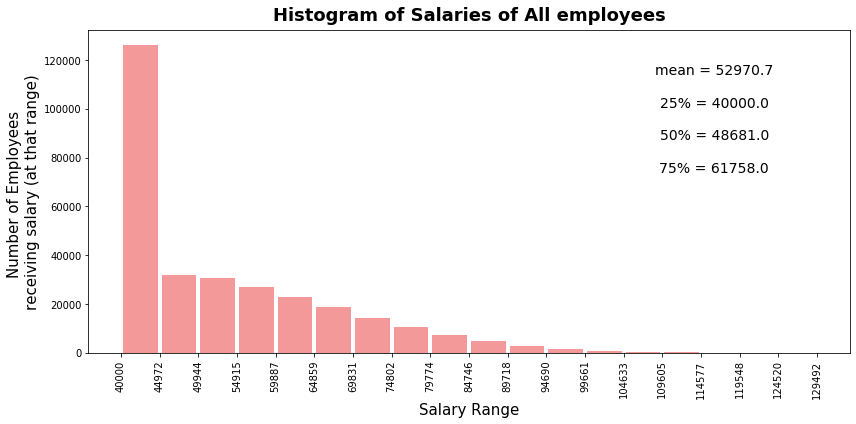

In [125]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,6))
#_=Employee_Salary_DF.hist(column='salary', ax=ax, color='lightcoral', alpha=0.8, grid=False, bins=16, rwidth=0.9, zorder=1)
n, bins, patches = ax.hist(Employee_Salary_DF['salary'], color='lightcoral', alpha=0.8,bins=18, rwidth=0.9, zorder=1)
_=ax.set_title("Histogram of Salaries of All employees", fontsize=18, weight='bold', y=1.01)
_=ax.set_xlabel('Salary Range',fontsize = 15)
_=ax.set_ylabel('Number of Employees \nreceiving salary (at that range)',fontsize = 15)


#Annotation
#Mean, 25%, 50%(Median), 75% quartiles
label = '\n\n'.join(Employee_Salary_DF['salary'].describe().iloc[[1,4,5,6]].reset_index().apply(lambda x: "{} = {:.1f}".format(x['index'], x['salary']), axis=1).to_list())
(x,y) = (115000, 70000)
_=ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text ('offset pixels'  is the other option)
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 fontsize=14,
                 color='k')
_=plt.xticks(bins, rotation=90)
_ = plt.tight_layout()
_= plt.savefig('../Images/histogram.png', bbox_inches = "tight" )


## Create a bar chart of average salary by title.

### Direct SQL query result to pandas DF

In [143]:
query = "SELECT titles.title, AVG(sal.salary) AS Average_Salary \
FROM employees AS emp \
LEFT JOIN salaries AS sal ON emp.emp_no = sal.emp_no \
LEFT JOIN titles ON emp.emp_title_id = titles.title_id \
GROUP BY titles.title \
ORDER BY Average_Salary DESC"

Employee_title_Agg_Salary_DF = pd.read_sql(
            query,
            con=connection
)

2020-07-13 21:16:33,429 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2020-07-13 21:16:33,432 INFO sqlalchemy.engine.base.Engine {'name': 'SELECT titles.title, AVG(sal.salary) AS Average_Salary FROM employees AS emp LEFT JOIN salaries AS sal ON emp.emp_no = sal.emp_no LEFT JOIN titles ON emp.emp_title_id = titles.title_id GROUP BY titles.title ORDER BY Average_Salary DESC'}
2020-07-13 21:16:33,437 INFO sqlalchemy.engine.base.Engine SELECT titles.title, AVG(sal.salary) AS Average_Salary FROM employees AS emp LEFT JOIN salaries AS sal ON emp.emp_no = sal.emp_no LEFT JOIN titles ON emp.emp_title_id = titles.title_id GROUP BY titles.title ORDER BY Average_Salary DESC
2020-07-13 21:16:33,438 INFO sqlalchemy.engine.base.Engine {}


In [144]:
Employee_title_Agg_Salary_DF

,title,average_salary
0,Senior Staff,58550.172704
1,Staff,58465.382850
2,Manager,51531.041667
3,Technique Leader,48582.896092
4,Assistant Engineer,48564.434447
5,Engineer,48535.336511
6,Senior Engineer,48506.799871


### Create bar chart
- **All the technical positions have less average salary compared to managerial positions**
- **Senior Engineer position has less average salary than Engineer and Assistant Engineer. This is a proof that this data is fake**

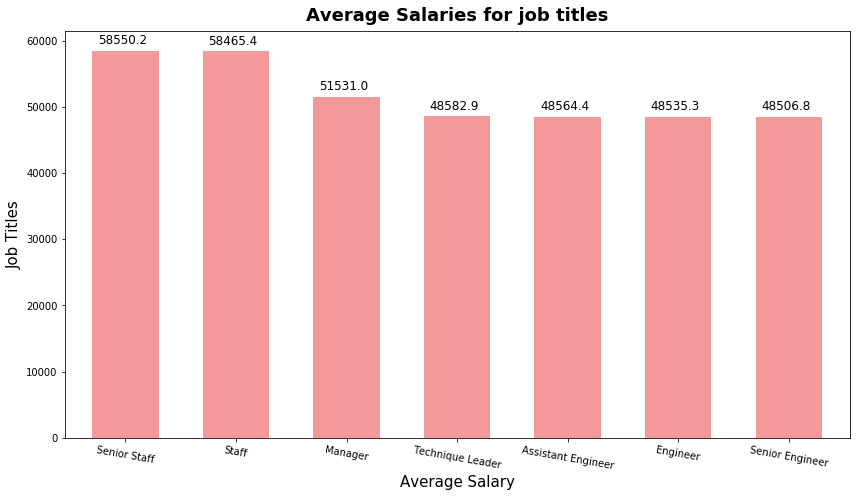

In [173]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,7))
#_=Employee_Salary_DF.hist(column='salary', ax=ax, color='lightcoral', alpha=0.8, grid=False, bins=16, rwidth=0.9, zorder=1)
_=Employee_title_Agg_Salary_DF.plot.bar(x='title', y='average_salary',color='lightcoral',alpha=0.8, ax=ax, legend=None, width=0.6, rot=-10)
_=ax.set_title("Average Salaries for job titles", fontsize=18, weight='bold', y=1.01)
_=ax.set_xlabel('Average Salary',fontsize = 15)
_=ax.set_ylabel('Job Titles',fontsize = 15)

#Annotate
for p in ax.patches:
    _=ax.annotate("{:.1f}".format(p.get_height()), (p.get_x()+0.05, p.get_height()+1000), fontsize=12)
    
_ = plt.tight_layout()
_= plt.savefig('../Images/Avg_salary_per_title.png', bbox_inches = "tight" )

